In [1]:
import torch
from torch import nn
import math
from torch.autograd import grad
from torch.autograd.functional import jvp


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super(SinusoidalPositionEmbeddings,self).__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = (self.dim) // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class MLP(nn.Module):
    def __init__(self, n_in, n_out, final_activation=nn.Identity()):
        super(MLP,self).__init__()

        self.layer_x = nn.Linear(n_in, 512)
        self.activation1 = nn.Tanh()

        #Time position embedding used in Transformers and Diffusion Models
        self.layer_pos = SinusoidalPositionEmbeddings(512)
        self.layer_time = nn.Linear(512, 512)
        self.activation2 = nn.GELU()
        self.layer_time2 = nn.Linear(512, 512)

        self.layer_fusion = nn.Linear(512, 512)
        self.activation3 = nn.Tanh()
        self.layer_out = nn.Linear(512, n_out)
        self.activation4 = final_activation

    def forward(self, x, time):

        x = self.layer_x(x)
        x = self.activation1(x)

        time = self.layer_pos(time)
        time = self.layer_time(time)
        time = self.activation2(time)
        time = self.layer_time2(time)

        x = self.layer_fusion(x+time)
        x = self.activation3(x)
        x = self.layer_out(x)
        x = self.activation4(x)
        return x


class WavePDE(nn.Module):
    def __init__(self, num_support_sets, num_support_timesteps, support_vectors_dim):
        """

        Args:
            num_support_sets (int)    : number of MLPs
            num_support_timesteps (int) : number of timestamps
            support_vectors_dim (int) : dimensionality of latent code
            learn_alphas (bool)       :
            learn_gammas (bool)       :
            gamma (float)             :
        """
        super(WavePDE, self).__init__()
        self.num_support_sets = num_support_sets
        self.num_support_timesteps = num_support_timesteps
        self.support_vectors_dim = support_vectors_dim
        self.c = nn.Parameter(torch.ones(num_support_sets,1,requires_grad=True))

        self.MLP_SET= nn.ModuleList([MLP(n_in=support_vectors_dim,n_out=1) for i in range(num_support_sets)])

    #Loss of initial condition
    def loss_ic(self,mlp,z):
        z = z.clone().requires_grad_()
        #z.requires_grad = True
        u = mlp(z, torch.zeros(1, dtype=z.dtype, device=z.device))
        u_z = grad(u.sum(), z, create_graph=True)[0]
        mse_0 =  torch.mean(torch.square(u_z))
        return mse_0

    #Loss of PDE
    def loss_pde(self,mlp,z,t,c,generator):
        z = z.clone().requires_grad_()
        #z.requires_grad = True
        t = t.clone().to(z).requires_grad_()
        #t.requires_grad = True

        u = mlp(z, t)
        u_t = grad(u.sum(), t, create_graph=True)[0]
        u_tt = grad(u_t.sum(), t, create_graph=True)[0]

        u_z = grad(u.sum(), z, create_graph=True)[0]
        u_zz = grad(u_z.sum(), z, create_graph=True)[0]

        #PDE
        pde = u_tt - (c**2) * (u_zz)

        mse_pde = torch.mean(torch.square(pde))
        return mse_pde , u_z, u

    #Loss of Jacobian-vector product (ensure current step would maximize data variations)
    def loss_jvp(self,mlp,z,t,generator):
        z = z.clone().requires_grad_()
        # z.requires_grad = True
        t = t.clone().to(z).requires_grad_()
        # t.requires_grad = True
        u = mlp(z, t)
        u_z = grad(u.sum(), z, create_graph=True)[0]
        z = z + u_z
        u_1 = mlp(z, t + 1)
        u_z1 = grad(u_1.sum(), z, create_graph=True)[0]
        # JVP
        _, jvp_value = jvp(generator, z, v=u_z1, create_graph=True)
        mse_jvp = torch.mean(torch.square(jvp_value))
        return mse_jvp, u_z1


    def forward(self, index, z, t, generator):
        mse_ic =0.0# self.loss_ic(self.MLP_SET[index],z)
        mse_pde = 0.0
        half_range = self.num_support_timesteps // 2
        for i in range(0,half_range):
            t_index = torch.tensor([[i]], dtype=z.dtype, device=z.device, requires_grad=True)
            mse_pde_t_index, u_z , u = self.loss_pde(self.MLP_SET[index],z,t_index,self.c[index],generator)
            if i == int(t[0]):
                mse_jvp, u_z1 = self.loss_jvp(self.MLP_SET[index], z, t_index, generator)
                energy = u
                latent1 = z + u_z
                latent2 = z + u_z + u_z1
            z = z + u_z
            mse_pde = mse_pde + mse_pde_t_index
        loss = mse_ic + mse_pde/half_range - mse_jvp
        return energy, latent1, latent2, loss

    def inference(self, index, z, t, generator):
        _, u_z, u = self.loss_pde(self.MLP_SET[index], z, t, self.c[index], generator)
        return u, u_z


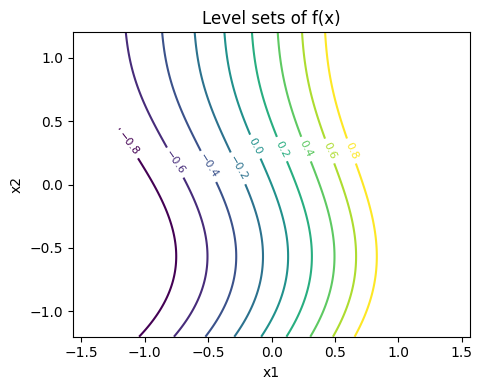

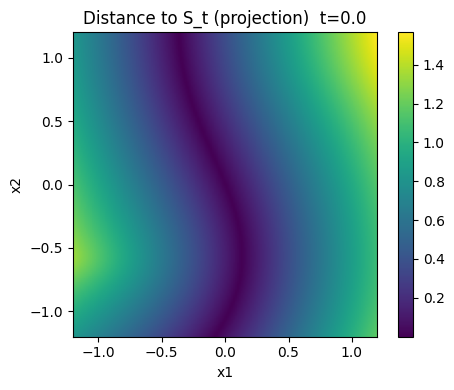

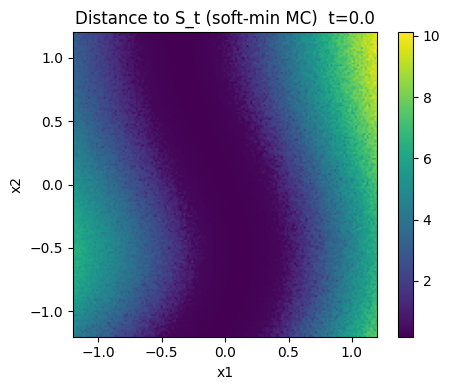

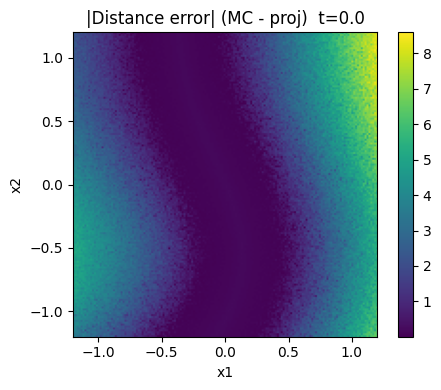

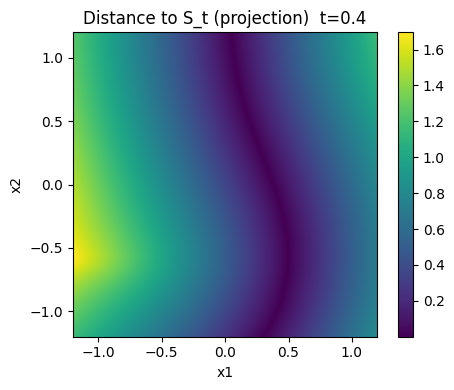

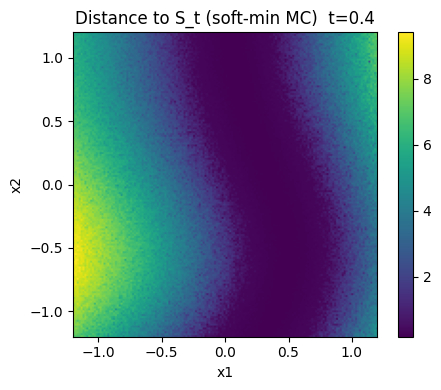

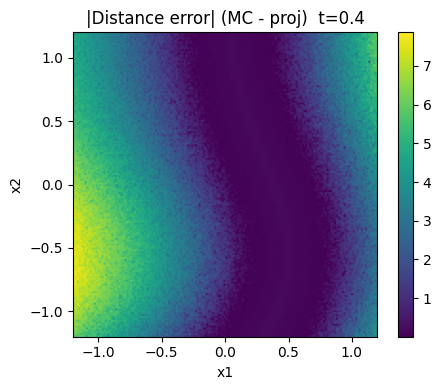

t=0.0:  psi MAE=5.6012, psi RMSE=9.8487, d MAE=1.9607, d RMSE=2.7565  |  project 0.34s, MC 0.28s
t=0.4:  psi MAE=6.7516, psi RMSE=11.2960, d MAE=2.2004, d RMSE=3.0286  |  project 0.01s, MC 0.00s
Vector-field angle median (deg) t=0.0: 2.27 | 75th pct: 4.55 | 90th pct: 8.33


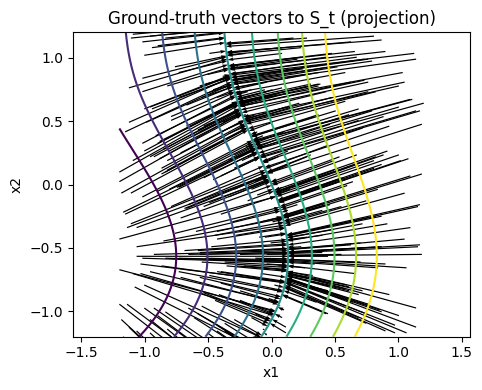

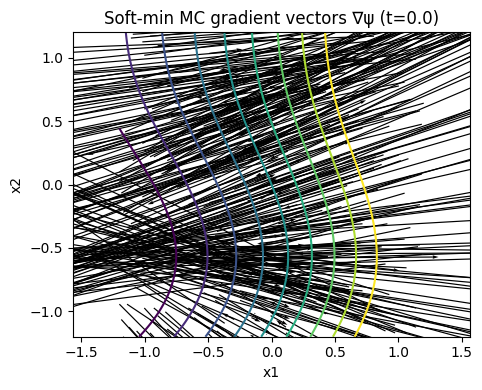

In [2]:
# Soft-min (Approach B) demo in PyTorch for the user's example f(x)
# This notebook cell:
# 1) defines f(x) from the prompt
# 2) implements psi via soft-min Monte Carlo (Approach B)
# 3) builds a "ground-truth" approximation using a few normal-projection steps (Option A) for comparison
# 4) evaluates on a grid for two target levels t and visualizes: level sets, ground-truth distance, soft-min distance, and error
# 5) prints quantitative errors (MAE/RMSE) for psi and distance
#
# Notes:
# - Each plot is a separate figure (no subplots), per instructions.
# - No explicit colors or styles are set.
# - Everything runs on CPU for reproducibility.

import math, time, sys, numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("mps")
torch.set_default_dtype(torch.float32)

# ---- User's model f(x) ----
@torch.enable_grad()
def f_torch(x):
    # x: [..., 2]
    x1, x2 = x[..., 0], x[..., 1]
    y = x1 + 0.15*(x1**2 + x2**2) + 0.2*torch.sin(2.0*x2)
    return y.unsqueeze(-1)  # [..., 1]

# ---- Soft-min Monte Carlo psi (Approach B) ----
# W_{eps,delta}(x,t) = -2 eps^2 log E[ exp( - chi_delta(f(x+eps*xi)-t) / (2 eps^2) ) ]
# chi_delta(s) = s^2 / (2 delta^2)
# psi(x,t) ~ -0.5 * W

def psi_softmin_mc(f, x, t, eps=0.1, delta=0.1, K=64, seed=None):
    """
    x: [B,2], t: [B,1] or [B]
    returns psi: [B,1]
    """
    if t.dim()==1: t = t[:,None]
    B, d = x.shape
    if seed is not None:
        g = torch.Generator(device=device)
        g.manual_seed(seed)
        xi = torch.randn(B, K, d, device=device, generator=g)
    else:
        xi = torch.randn(B, K, d, device=device)
    z = x[:,None,:] + eps * xi                            # [B,K,2]
    y = f(z.reshape(B*K, d)).reshape(B, K, 1).squeeze(-1) # [B,K]
    band = 0.5 * ((y - t)**2) / (delta**2)                # [B,K]
    a = - band / (2*eps**2)                               # [B,K]
    m = a.max(dim=1, keepdim=True).values
    logmeanexp = (a - m).exp().mean(dim=1).log() + m.squeeze(1)
    W = -2 * (eps**2) * logmeanexp[:,None]                # [B,1]
    return -0.5 * W

# Optional: gradient of psi wrt x via autograd
def grad_x_psi_softmin_mc(f, x, t, eps=0.1, delta=0.1, K=64):
    x = x.detach().requires_grad_(True)
    psi = psi_softmin_mc(f, x, t, eps=eps, delta=delta, K=K)
    g, = torch.autograd.grad(psi.sum(), x, create_graph=False)
    return psi.detach(), g.detach()

# ---- "Ground-truth" via few normal projection steps (Option A) ----

def project_to_levelset_normal(f, x, t, steps=10, eps=1e-8, step_cap=0.5):
    """
    Returns z_proj ~ projection of x onto S_t, using normal-Newton updates.
    x: [B,2], t: [B,1] or [B]
    Pure first-order method; does NOT build a large computation graph.
    """
    if t.dim()==1: t = t[:,None]
    z = x.clone().detach()
    for k in range(steps):
        z_ = z.clone().detach().requires_grad_(True)
        y = f(z_)
        g, = torch.autograd.grad(y.sum(), z_, retain_graph=False, create_graph=False)
        r = (y.detach() - t)                        # [B,1], detach residual
        denom = g.pow(2).sum(-1, keepdim=True) + eps
        s = (r / denom).clamp(min=-step_cap, max=step_cap)
        z = (z_ - s * g).detach()
        if (r.abs().max() < 1e-5).item():
            break
    return z

def psi_via_projection(f, x, t, steps=10):
    z = project_to_levelset_normal(f, x, t, steps=steps)
    d = (z - x).pow(2).sum(-1, keepdim=True).sqrt()
    psi = -0.5 * d.pow(2)
    return psi, d, z


# ---- Grid / test setup ----
box_lo, box_hi = -1.2, 1.2
N = 160  # grid size per axis
xs = np.linspace(box_lo, box_hi, N)
ys = np.linspace(box_lo, box_hi, N)
XX, YY = np.meshgrid(xs, ys, indexing='xy')
grid = torch.tensor(np.stack([XX, YY], axis=-1), dtype=torch.float32, device=device).view(-1,2)

# Choose two target levels to test
with torch.no_grad():
    center = torch.tensor([[0.0, 0.0]], device=device)
    f_center = f_torch(center)[0,0].item()
t_levels = [0.0, 0.4]

# Visualize level sets of f (as in the prompt)
with torch.no_grad():
    ZZ = f_torch(torch.tensor(np.stack([XX,YY],axis=-1), dtype=torch.float32)).squeeze(-1).numpy()
plt.figure(figsize=(5,4))
cs = plt.contour(XX, YY, ZZ, levels=np.linspace(-0.8,0.8,9))
plt.clabel(cs, inline=True, fontsize=8)
plt.title("Level sets of f(x)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.tight_layout(); plt.show()

# ---- Evaluation loop over t-levels ----
results = {}
for t_val in t_levels:
    t_grid = torch.full((grid.shape[0], 1), float(t_val), device=device)

    # Ground truth via projection (Option A), a few steps only for speed
    t0 = time.time()
    psi_gt, d_gt, z_gt = psi_via_projection(f_torch, grid, t_grid, steps=15)
    t1 = time.time()

    # Soft-min MC (Approach B)
    eps = 0.10
    delta = 0.10
    K = 96*4
    t2 = time.time()
    psi_mc = psi_softmin_mc(f_torch, grid, t_grid, eps=eps, delta=delta, K=K)
    t3 = time.time()

    # Distances from psi: d = sqrt(-2 psi), clamp for numerical safety
    d_mc = (-2.0 * psi_mc).clamp_min(0).sqrt()

    # Errors
    psi_mae = (psi_mc - psi_gt).abs().mean().item()
    psi_rmse = ((psi_mc - psi_gt).pow(2).mean().sqrt()).item()
    d_mae = (d_mc - d_gt).abs().mean().item()
    d_rmse = ((d_mc - d_gt).pow(2).mean().sqrt()).item()

    results[t_val] = dict(
        psi_gt=psi_gt.view(N,N,1).cpu().numpy(),
        psi_mc=psi_mc.view(N,N,1).cpu().numpy(),
        d_gt=d_gt.view(N,N,1).cpu().numpy(),
        d_mc=d_mc.view(N,N,1).cpu().numpy(),
        timings=dict(project_s= t1-t0, mc_s= t3-t2),
        metrics=dict(psi_mae=psi_mae, psi_rmse=psi_rmse, d_mae=d_mae, d_rmse=d_rmse),
        eps=eps, delta=delta, K=K
    )

    # --- Plots for this t ---
    # Ground-truth distance heatmap
    plt.figure(figsize=(5,4))
    plt.imshow(results[t_val]["d_gt"][...,0], origin='lower',
               extent=[box_lo, box_hi, box_lo, box_hi], aspect='equal')
    plt.colorbar()
    plt.title(f"Distance to S_t (projection)  t={t_val}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

    # Soft-min MC distance heatmap
    plt.figure(figsize=(5,4))
    plt.imshow(results[t_val]["d_mc"][...,0], origin='lower',
               extent=[box_lo, box_hi, box_lo, box_hi], aspect='equal')
    plt.colorbar()
    plt.title(f"Distance to S_t (soft-min MC)  t={t_val}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

    # Absolute error heatmap
    plt.figure(figsize=(5,4))
    err = np.abs(results[t_val]["d_mc"][...,0] - results[t_val]["d_gt"][...,0])
    plt.imshow(err, origin='lower',
               extent=[box_lo, box_hi, box_lo, box_hi], aspect='equal')
    plt.colorbar()
    plt.title(f"|Distance error| (MC - proj)  t={t_val}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

# ---- Print metrics ----
for t_val, out in results.items():
    m = out["metrics"]; times = out["timings"]
    print(f"t={t_val}:  psi MAE={m['psi_mae']:.4f}, psi RMSE={m['psi_rmse']:.4f}, "
          f"d MAE={m['d_mae']:.4f}, d RMSE={m['d_rmse']:.4f}  |  "
          f"project {times['project_s']:.2f}s, MC {times['mc_s']:.2f}s")

# ---- Optional: vector-field sanity check at sparse points for t=0.0 ----
# Compare gradient of psi_mc to the ground-truth vector-to-surface (z - x).
t_val = t_levels[0]
Bsample = 400
idx = torch.randperm(grid.shape[0])[:Bsample]
x_s = grid[idx].detach()
t_s = torch.full((Bsample,1), float(t_val), device=device)
z_s = project_to_levelset_normal(f_torch, x_s, t_s, steps=15)
vec_gt = (z_s - x_s)  # [B,2]
psi_s, grad_mc = grad_x_psi_softmin_mc(f_torch, x_s, t_s, eps=results[t_val]["eps"],
                                       delta=results[t_val]["delta"], K=results[t_val]["K"])
# Normalize for angle comparison
def angle(a,b,eps=1e-8):
    num = (a*b).sum(-1)
    den = (a.pow(2).sum(-1).sqrt() * b.pow(2).sum(-1).sqrt() + eps)
    return torch.acos((num/den).clamp(-1+1e-6, 1-1e-6))

ang = angle(grad_mc, vec_gt).cpu().numpy()
print(f"Vector-field angle median (deg) t={t_val}: {np.median(ang)*180/np.pi:.2f} | "
      f"75th pct: {np.percentile(ang,75)*180/np.pi:.2f} | "
      f"90th pct: {np.percentile(ang,90)*180/np.pi:.2f}")

# Quiver plot (sparse) to visualize alignment; overplot a few level sets
xq = x_s.cpu().numpy()
vg = vec_gt.cpu().numpy()
vm = grad_mc.cpu().numpy()

plt.figure(figsize=(5,4))
plt.contour(XX, YY, ZZ, levels=np.linspace(-0.8,0.8,9))
plt.quiver(xq[:,0], xq[:,1], vg[:,0], vg[:,1], angles='xy', scale_units='xy', scale=1)
plt.title("Ground-truth vectors to S_t (projection)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.contour(XX, YY, ZZ, levels=np.linspace(-0.8,0.8,9))
plt.quiver(xq[:,0], xq[:,1], vm[:,0], vm[:,1], angles='xy', scale_units='xy', scale=1)
plt.title("Soft-min MC gradient vectors ∇ψ (t=0.0)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.tight_layout(); plt.show()


In [ ]:
import torch
import torch.nn as nn
from typing import Tuple, Optional

# --- A tiny test "f" model (replace with your own) ----------------------------
class ToyF(nn.Module):
    """
    Example scalar field f(x) = x0 + 0.25 * x1^2  (R^2 -> R).
    Works with batched inputs (..., d).
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape (..., 2)
        return x[..., 0] + 0.25 * (x[..., 1] ** 2)  # shape (...,)

# --- The psi module -----------------------------------------------------------
class SoftLevelSetPsi(nn.Module):
    """
    Compute psi(x,t) ≈ ε^2 * log E_{ξ~N(0,I)}[ exp( - (f(x+εξ)-t)^2 / (4 ε^2 δ^2) ) ]
    via reparameterized Monte Carlo, fully differentiable.

    Args:
        f:        nn.Module or callable, scalar field f(x) -> (...,) or (...,1)
        eps:      ε, spatial smoothing (float)
        delta:    δ, level band width (float)
        nsamples: number of MC samples (int)
        antithetic: if True, uses ξ and -ξ pairs (variance reduction)
        adaptive_band: if True, uses δ(x) = kappa * eps * ||∇f(x)|| (scalar f only)
        kappa:    factor for adaptive band
    """
    def __init__(self, f: nn.Module,
                 eps: float = 0.25,
                 delta: float = 0.25,
                 nsamples: int = 128,
                 antithetic: bool = True,
                 adaptive_band: bool = False,
                 kappa: float = 1.0):
        super().__init__()
        self.f = f
        self.eps = float(eps)
        self.delta = float(delta)
        self.nsamples = int(nsamples)
        self.antithetic = bool(antithetic)
        self.adaptive_band = bool(adaptive_band)
        self.kappa = float(kappa)

    @staticmethod
    def _logmeanexp(a: torch.Tensor, dim: int) -> torch.Tensor:
        # numerically stable log(mean(exp(a))) along dim
        m = a.max(dim=dim, keepdim=True).values
        return (m + torch.log(torch.clamp(torch.mean(torch.exp(a - m), dim=dim), min=1e-20))).squeeze(dim)

    def _delta_eff(self, x: torch.Tensor) -> torch.Tensor:
        if not self.adaptive_band:
            return torch.full((x.shape[0],), self.delta, device=x.device, dtype=x.dtype)  # (B,)
        # Estimate ||∇f(x)|| for scalar f
        x_req = x.detach().requires_grad_(True)
        fx = self.f(x_req)  # (B,) or (B,1)
        if fx.ndim == 2 and fx.shape[-1] == 1:
            fx = fx.squeeze(-1)
        ones = torch.ones_like(fx)
        (grad_x,) = torch.autograd.grad(fx, x_req, grad_outputs=ones, create_graph=False, retain_graph=False)
        gn = grad_x.norm(dim=-1) + 1e-12  # (B,)
        return self.kappa * self.eps * gn

    def forward(self, x: torch.Tensor, t: torch.Tensor,
                return_projection: bool = False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        x: (B, d)
        t: (B,) or () or (B,1)   (scalar target level)
        return: psi (B,) and optionally Π̂_t(x) (B,d) ~ soft projection (posterior mean)
        """
        assert x.ndim == 2, "x must be (B, d)"
        B, d = x.shape
        device, dtype = x.device, x.dtype

        # number of samples (use antithetics if requested)
        ns = self.nsamples
        if self.antithetic:
            ns_half = max(1, ns // 2)
            xi = torch.randn(ns_half, B, d, device=device, dtype=dtype)
            xi = torch.cat([xi, -xi], dim=0)  # (ns, B, d)
            ns = xi.shape[0]
        else:
            xi = torch.randn(ns, B, d, device=device, dtype=dtype)

        # sample points around x
        z = x.unsqueeze(0) + self.eps * xi         # (ns, B, d)

        # evaluate f on all samples
        fz = self.f(z.reshape(ns * B, d)).reshape(ns, B)  # (ns,B), scalar field

        # normalize t shape
        if t.ndim == 0:                # scalar -> (B,)
            t = t.expand(B)
        if t.ndim == 2 and t.shape[-1] == 1:
            t = t.squeeze(-1)
        t = t.view(1, B).expand(ns, B)  # (ns,B)

        # effective delta: fixed or adaptive per batch element
        delta_eff = self._delta_eff(x)                  # (B,)
        delta2 = (delta_eff ** 2).view(1, B).expand(ns, B)

        # exponent a = - (f(z)-t)^2 / (4 ε^2 δ^2)
        a = - ((fz - t) ** 2) / (4.0 * (self.eps ** 2) * delta2)  # (ns,B)

        # psi = ε^2 * log E[exp(a)]
        logm = self._logmeanexp(a, dim=0)  # (B,)
        psi = (self.eps ** 2) * logm       # (B,)

        if not return_projection:
            return psi, None

        # Optional soft projection: Π̂ ≈ E[Z] under Gibbs weights ∝ exp(a)
        w = torch.softmax(a, dim=0)            # (ns,B)
        Ez = (w.unsqueeze(-1) * z).sum(dim=0)  # (B,d)
        return psi, Ez  # Π̂_t(x) ≈ Ez
        

# --- Example end-to-end module wiring -----------------------------------------
class PsiModel(nn.Module):
    """
    A full model whose forward returns psi(x,t) computed for its internal f.
    Swap ToyF for your own trained network.
    """
    def __init__(self):
        super().__init__()
        self.f = ToyF()  # Or your nn.Module mapping R^d -> R
        self.psi_layer = SoftLevelSetPsi(self.f, eps=0.3, delta=0.3, nsamples=128,
                                         antithetic=False, adaptive_band=False)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        psi, _ = self.psi_layer(x, t, return_projection=False)
        return psi  # shape (B,)

# --- Minimal usage demo -------------------------------------------------------
if __name__ == "__main__":
    torch.manual_seed(0)
    model = PsiModel()

    # batch of points in R^2
    x = torch.tensor([[0.0, -2.0],
                      [1.0,  0.5],
                      [-0.5, 3.0]], dtype=torch.float32)

    # one level per point (can also pass a scalar, e.g., t=torch.tensor(0.0))
    t = torch.tensor([0.0, 0.5, 1.0], dtype=torch.float32)

    psi_vals = model(x, t)           # (B,)
    print("psi(x,t) =", psi_vals)

    # If you want ∇_x psi, autograd works end-to-end:
    x_req = x.clone().requires_grad_(True)
    psi_vals = model(x_req, t).sum()  # sum so grad is (B,d)
    psi_vals.backward()
    print("grad_x psi =", x_req.grad)

psi(x,t) = tensor([-0.4558, -0.2443, -0.2268])
grad_x psi = tensor([[-0.8829,  0.7032],
        [-0.4249, -0.0755],
        [-0.2014, -0.2735]])


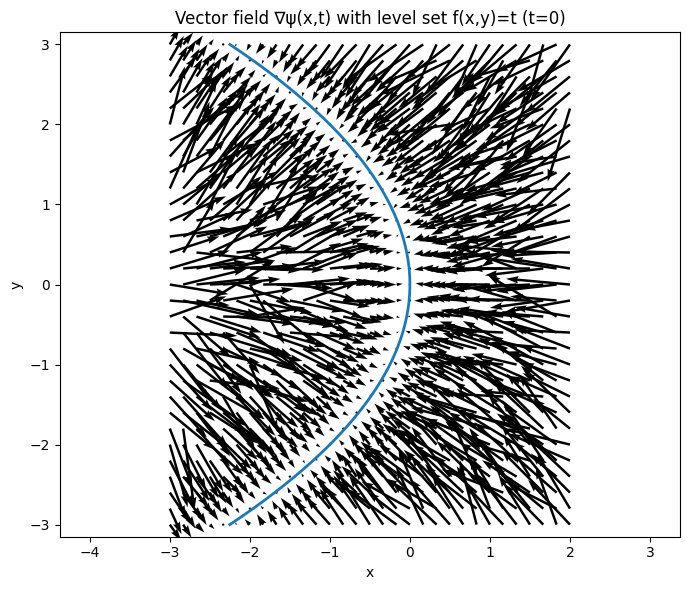

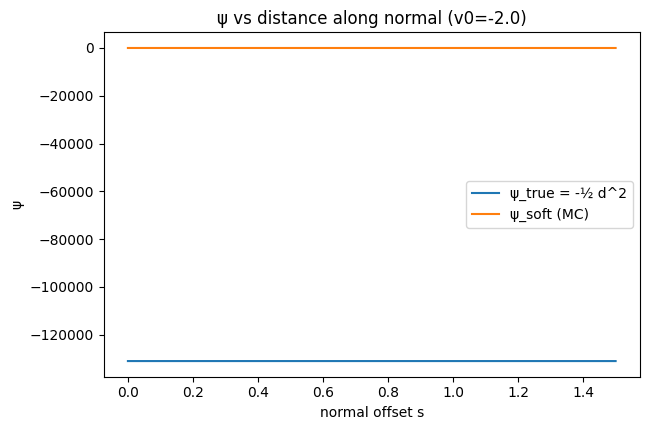

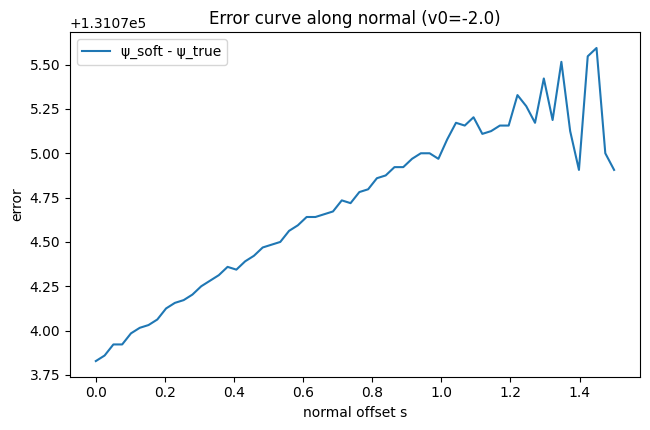

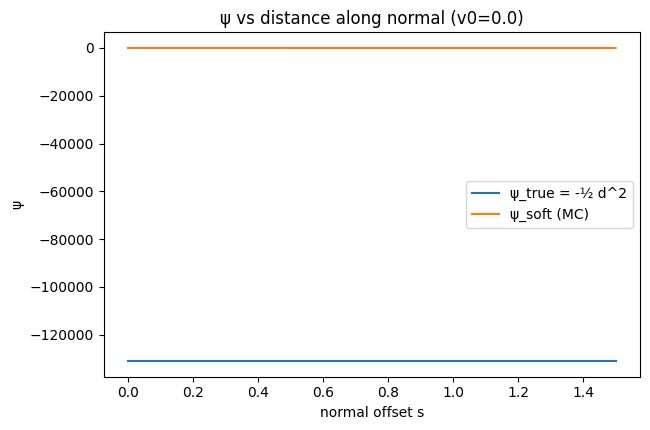

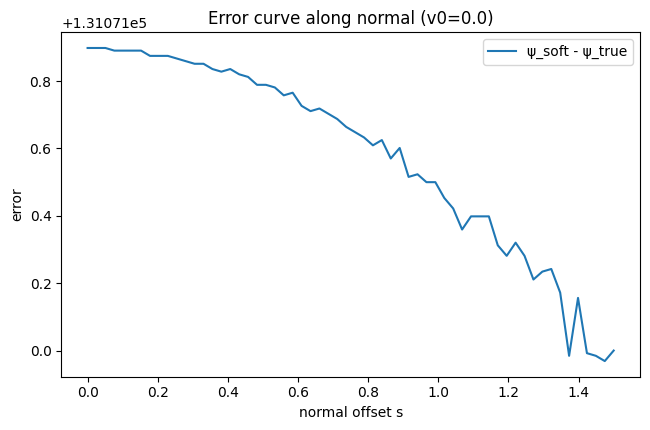

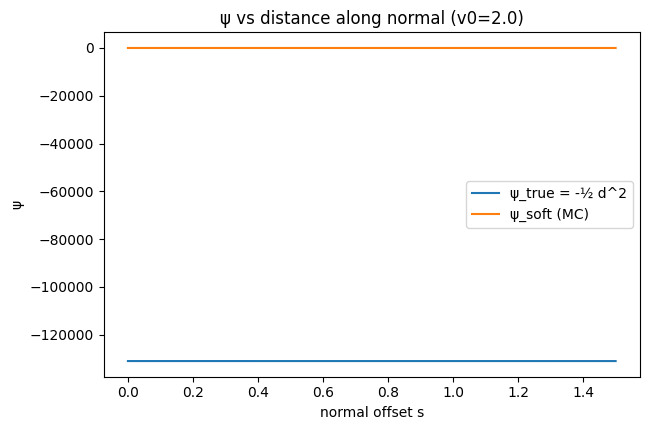

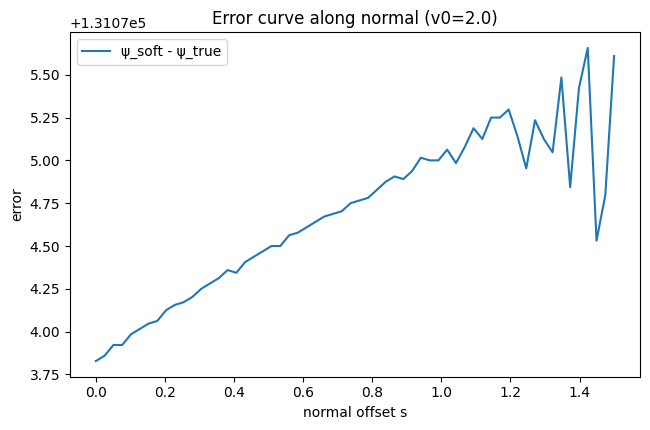

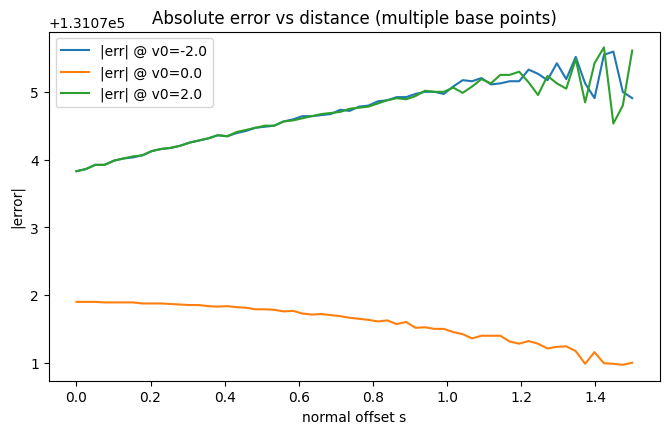

NameError: name 'vf_path' is not defined

In [42]:
# Full 2D vector field visualization and error curves (separate charts, no subplots)
# Uses the SoftLevelSetPsi estimator on a toy curved level set f(x,y)=x + 0.25*y^2 = t.
# Produces: 
#  - Quiver plot of ∇_x psi over a grid with the level set overlayed
#  - Separate line charts showing psi_soft vs psi_true and the error vs distance along normals from three base points
#
# Note: The environment guideline asks for one chart per figure (no subplots) and no explicit color settings.

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

torch.manual_seed(0)

# ------------------------ Model definitions ------------------------

class ToyF(nn.Module):
    """Example scalar field f(x) = x + 0.25*y^2 (R^2 -> R)."""
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape (..., 2)
        return x[..., 0] + 0.25 * (x[..., 1] ** 2)  # shape (...,)

class SoftLevelSetPsi(nn.Module):
    """
    Compute psi(x,t) ≈ ε^2 * log E_{ξ~N(0,I)}[ exp( - (f(x+εξ)-t)^2 / (4 ε^2 δ^2) ) ]
    via reparameterized Monte Carlo, fully differentiable.
    Also returns soft projection Π̂_t(x) ≈ E[Z] if requested.
    """
    def __init__(self, f: nn.Module,
                 eps: float = 0.30,
                 delta: float = 0.30,
                 nsamples: int = 256,
                 antithetic: bool = True):
        super().__init__()
        self.f = f
        self.eps = float(eps)
        self.delta = float(delta)
        self.nsamples = int(nsamples)
        self.antithetic = bool(antithetic)

    @staticmethod
    def _logmeanexp(a: torch.Tensor, dim: int) -> torch.Tensor:
        m = a.max(dim=dim, keepdim=True).values
        return (m + torch.log(torch.clamp(torch.mean(torch.exp(a - m), dim=dim), min=1e-20))).squeeze(dim)

    def forward(self, x: torch.Tensor, t: torch.Tensor, return_projection: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        assert x.ndim == 2
        B, d = x.shape
        device, dtype = x.device, x.dtype

        ns = self.nsamples
        if self.antithetic:
            ns_half = max(1, ns // 2)
            xi = torch.randn(ns_half, B, d, device=device, dtype=dtype)
            xi = torch.cat([xi, -xi], dim=0)
            ns = xi.shape[0]
        else:
            xi = torch.randn(ns, B, d, device=device, dtype=dtype)

        z = x.unsqueeze(0) + self.eps * xi            # (ns,B,d)
        fz = self.f(z.reshape(ns * B, d)).reshape(ns, B)  # (ns,B)

        if t.ndim == 0:
            t = t.expand(B)
        if t.ndim == 2 and t.shape[-1] == 1:
            t = t.squeeze(-1)
        t = t.view(1, B).expand(ns, B)

        delta2 = (self.delta ** 2)

        a = - ((fz - t) ** 2) / (4.0 * (self.eps ** 2) * delta2)  # (ns,B)
        logm = self._logmeanexp(a, dim=0)                         # (B,)
        psi = (self.eps ** 2) * logm                               # (B,)

        if not return_projection:
            return psi, None

        w = torch.softmax(a, dim=0)                  # (ns,B)
        Ez = (w.unsqueeze(-1) * z).sum(dim=0)        # (B,d)
        return psi, Ez


# ------------------------ Exact projection to the parabola level set ------------------------
# For f(x,y) = x + 0.25*y^2 and fixed t, the nearest point solves the KKT system.
# Derivation yields a 1D equation for lambda:
#   F(λ) = x0 - t - λ/2 + 4*x1^2 / (4 + λ)^2 = 0, with λ > -4.
# Then u = x0 - λ/2, v = 4*x1 / (4 + λ).
# We'll solve F(λ)=0 by vectorized bisection on (-4, +∞).

def project_to_level_parabola(x: torch.Tensor, t: float, iters: int = 80) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    x: (N,2) points
    t: scalar level
    returns: z_proj (N,2), dist (N,)
    """
    x0 = x[:, 0]
    x1 = x[:, 1]

    # Bisection bounds: (-3.999, big) ensures (4+λ)>0 to avoid singularity.
    lb = torch.full_like(x0, -3.999)
    ub = torch.full_like(x0, 1024.0)

    def F(lmb):
        return (x0 - t) - 0.5 * lmb + 4.0 * (x1 ** 2) / ((4.0 + lmb) ** 2)

    # Ensure signs: F(lb) > 0, F(ub) < 0 (monotone decreasing on (-4, ∞))
    Flb = F(lb)
    Fub = F(ub)
    # Small numeric nudges if needed
    # (In practice these conditions hold; we guard anyway)
    mask_fix = (Flb <= 0) | (Fub >= 0)
    if mask_fix.any():
        # Shift ub up and lb closer to -4 where needed
        ub = torch.where(mask_fix, torch.full_like(ub, 4096.0), ub)
        lb = torch.where(mask_fix, torch.full_like(lb, -3.99), lb)

    for _ in range(iters):
        mid = 0.5 * (lb + ub)
        Fmid = F(mid)
        go_left = Fmid > 0
        lb = torch.where(go_left, lb, mid)
        ub = torch.where(go_left, mid, ub)

    lmb = 0.5 * (lb + ub)
    u = x0 - 0.5 * lmb
    v = 4.0 * x1 / (4.0 + lmb)
    z = torch.stack([u, v], dim=1)
    dist = torch.linalg.norm(z - x, dim=1)
    return z, dist


# ------------------------ Build psi estimator on the toy field ------------------------

f = ToyF()
psi_layer = SoftLevelSetPsi(f, eps=0.35, delta=0.35, nsamples=256*4, antithetic=False)

# Fixed level set t (curved parabola)
t_level = torch.tensor(0.0)


# ------------------------ 2D vector field (∇_x psi) over a grid ------------------------

# Grid domain
x_min, x_max = -3.0, 2.0
y_min, y_max = -3.0, 3.0
nx, ny = 31, 31

xs = torch.linspace(x_min, x_max, nx)
ys = torch.linspace(y_min, y_max, ny)
XX, YY = torch.meshgrid(xs, ys, indexing='ij')
grid = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)  # (N,2)

# Compute psi and soft projection -> gradient = Ez - x
with torch.no_grad():
    psi_vals, Ez = psi_layer(grid, t_level, return_projection=True)
grad = (Ez - grid)  # (N,2)

# Prepare plot data
X = XX.numpy()
Y = YY.numpy()
U = grad[:, 0].reshape(nx, ny).numpy()
V = grad[:, 1].reshape(nx, ny).numpy()

# Level set curve points
v_curve = torch.linspace(y_min, y_max, 400)
u_curve = (t_level - 0.25 * v_curve**2)
u_np = u_curve.numpy()
v_np = v_curve.numpy()

plt.figure(figsize=(7, 6))
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1.5, width=0.004)
plt.plot(u_np, v_np, linewidth=2)
plt.title("Vector field ∇ψ(x,t) with level set f(x,y)=t (t=0)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.tight_layout()
plt.show()


# ------------------------ Error curves along normals from points on the curve ------------------------

def normal_at_curve_point(v0: float) -> Tuple[torch.Tensor, torch.Tensor]:
    """Return curve point z0 and outward normal (unit) at parameter v0 on the level set f=t."""
    z0 = torch.tensor([t_level.item() - 0.25 * (v0 ** 2), v0], dtype=torch.float32)
    grad_f = torch.tensor([1.0, 0.5 * v0], dtype=torch.float32)
    n = grad_f / torch.linalg.norm(grad_f)
    return z0, n

# choose three base points with different curvature regimes
v0_list = [-2.0, 0.0, 2.0]
s_vals = torch.linspace(0.0, 1.5, 60)

all_abs_errs = []

for v0 in v0_list:
    z0, n0 = normal_at_curve_point(v0)
    # Sample points along the outward normal ray
    Xs = z0.unsqueeze(0) + s_vals.unsqueeze(1) * n0.unsqueeze(0)  # (S,2)

    with torch.no_grad():
        psi_soft, _ = psi_layer(Xs, t_level, return_projection=False)  # (S,)
    # Exact distances by projection
    z_proj, d_exact = project_to_level_parabola(Xs, t_level.item())
    psi_true = -0.5 * (d_exact ** 2)

    # Errors
    err = (psi_soft - psi_true)
    all_abs_errs.append(err.abs().unsqueeze(0))

    # Chart 1: psi_soft vs psi_true (one chart per base point)
    plt.figure(figsize=(6.6, 4.4))
    plt.plot(s_vals.numpy(), psi_true.numpy(), label="ψ_true = -½ d^2")
    plt.plot(s_vals.numpy(), psi_soft.numpy(), label="ψ_soft (MC)")
    plt.xlabel("normal offset s")
    plt.ylabel("ψ")
    plt.title(f"ψ vs distance along normal (v0={v0:.1f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Chart 2: error vs s
    plt.figure(figsize=(6.6, 4.4))
    plt.plot(s_vals.numpy(), err.numpy(), label="ψ_soft - ψ_true")
    plt.xlabel("normal offset s")
    plt.ylabel("error")
    plt.title(f"Error curve along normal (v0={v0:.1f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Aggregate absolute error comparison (one chart, multiple series)
abs_err_mat = torch.cat(all_abs_errs, dim=0)  # (K,S)
plt.figure(figsize=(6.8, 4.6))
for i, v0 in enumerate(v0_list):
    plt.plot(s_vals.numpy(), abs_err_mat[i].numpy(), label=f"|err| @ v0={v0:.1f}")
plt.xlabel("normal offset s")
plt.ylabel("|error|")
plt.title("Absolute error vs distance (multiple base points)")
plt.legend()
plt.tight_layout()
plt.show()

vf_path, fig_path, err_path, agg_path


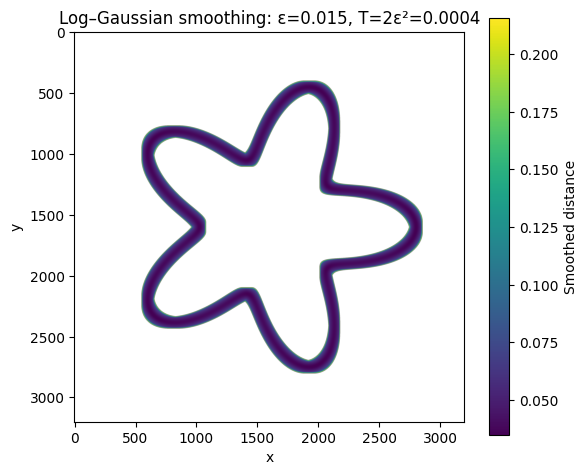

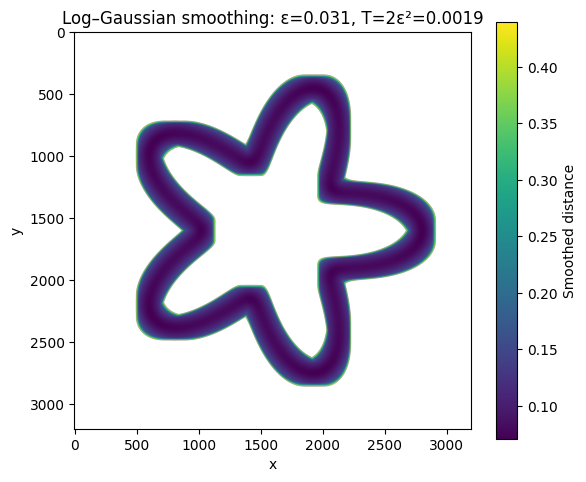

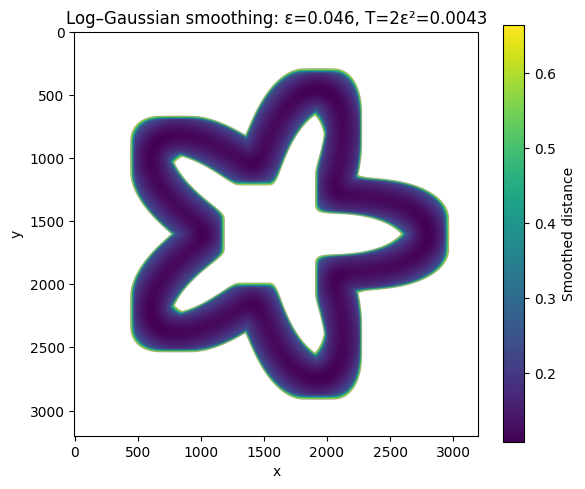

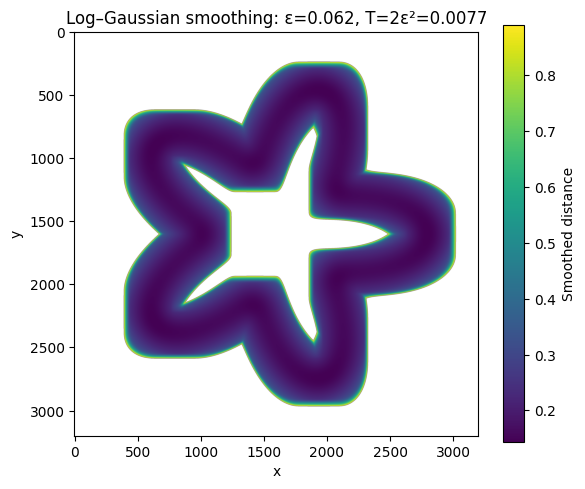

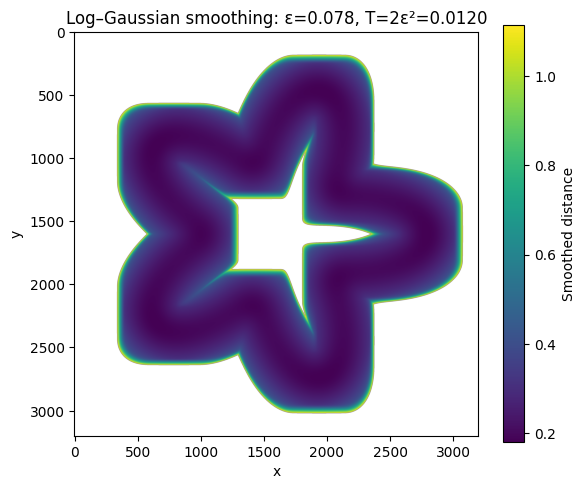

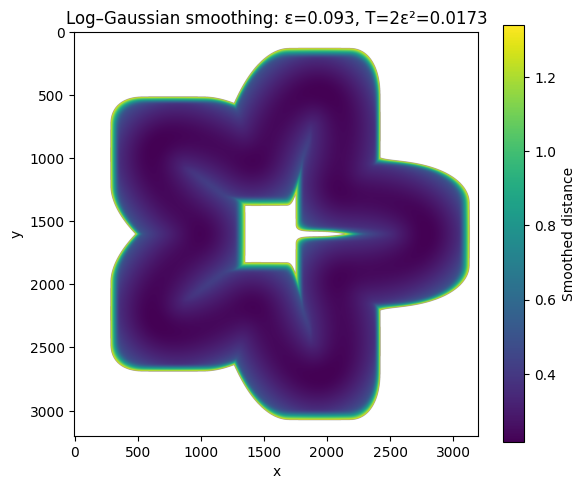

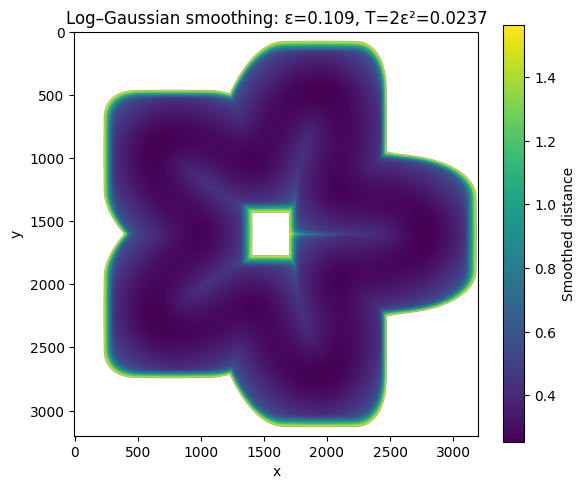

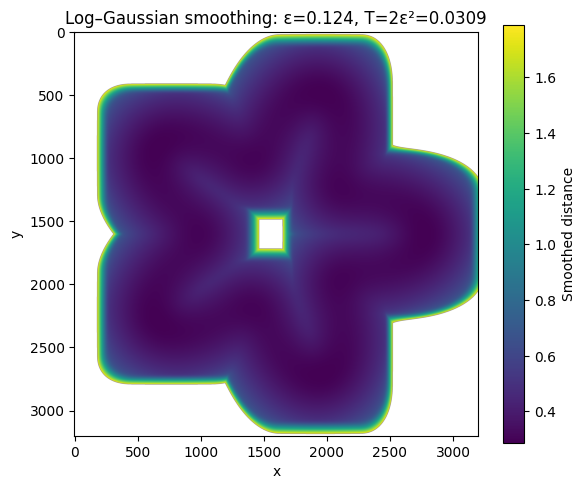

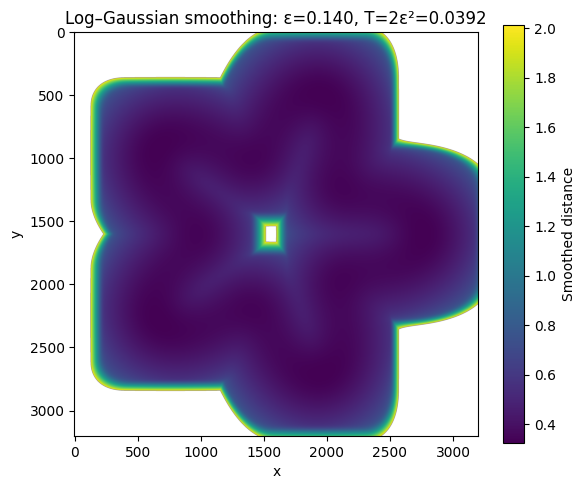

: 

In [ ]:
# Log-Gaussian smoothing demo with 9 temperatures (each shown as its own plot), rewritten to use PyTorch.
# The background color shows the base function f(x,y).
# The black curve marks the target level set S_t = {f = t}.
# Colored contour lines show the *log–Gaussian smoothed distance* approximation (varies with temperature).
#
# Notes:
# - We render *separate figures* instead of a 3x3 grid to comply with this environment's chart rules.
# - Function choice: a 5-petal "flower" boundary, which is highly nonconvex and a good stress-test for distance smoothing.
#
# Mathematical setup used in code:
#   f(x,y) := r - (1 + A*cos(5θ)) with r = sqrt(x^2+y^2), θ = atan2(y,x), A=0.35
#   Target level: t = 0  (the flower curve)
#   Penalty: χ_δ(s) = s^2 / (2 δ^2)
#   Temperature–variance link: T = 2 ε^2
#   Smoothed potential: ψ_{ε,δ}(x) = ε^2 * log( (G_ε * exp(-(f - t)^2 / (4 ε^2 δ^2)))(x) )
#   Distance approximation: d_{ε,δ}(x) ≈ sqrt(max(0, -2 ψ_{ε,δ}(x)))
#
# Libraries: torch, matplotlib

import torch
import matplotlib.pyplot as plt

def gaussian_kernel1d_torch(sigma_pix, truncate=3.0, device=None, dtype=None):
    """Return a 1D Gaussian kernel normalized to sum=1 (torch version)."""
    radius = max(1, int(truncate * sigma_pix + 0.5))
    x = torch.arange(-radius, radius + 1, dtype=dtype or torch.float32, device=device)
    if sigma_pix <= 0:
        k = torch.zeros_like(x)
        k[x==0] = 1.0
        return k
    k = torch.exp(-0.5 * (x / sigma_pix) ** 2)
    k /= k.sum()
    return k

def convolve_separable_torch(image, sigma_pix_y, sigma_pix_x, pad_mode="reflect"):
    """Apply separable Gaussian smoothing with given pixel sigmas along y and x (torch version)."""
    device = image.device
    dtype = image.dtype
    ky = gaussian_kernel1d_torch(sigma_pix_y, device=device, dtype=dtype)
    kx = gaussian_kernel1d_torch(sigma_pix_x, device=device, dtype=dtype)

    # Convolve along x (rows)
    pad_x = kx.numel() // 2
    arr = image
    if pad_x > 0:
        arr_pad = torch.nn.functional.pad(arr, (pad_x, pad_x), mode=pad_mode)
    else:
        arr_pad = arr
    out_x = torch.empty_like(arr)
    for i in range(arr.shape[0]):
        out_x[i, :] = torch.conv1d(
            arr_pad[i, :].unsqueeze(0).unsqueeze(0), 
            kx.flip(0).unsqueeze(0).unsqueeze(0), 
            padding=0
        ).squeeze()

    # Convolve along y (columns)
    pad_y = ky.numel() // 2
    if pad_y > 0:
        # torch.nn.functional.pad does not support non-constant padding for 1D input,
        # so we implement reflect padding manually for columns.
        if pad_mode == "reflect":
            arr_pad = torch.cat(
                [
                    out_x[:pad_y, :].flip(0),  # reflect top rows (exclude first row to avoid double)
                    out_x,
                    out_x[-pad_y:, :].flip(0)  # reflect bottom rows (exclude last row)
                ],
                dim=0
            )
        elif pad_mode == "replicate":
            arr_pad = torch.cat(
                [
                    out_x[0:1, :].expand(pad_y, -1),  # replicate first row
                    out_x,
                    out_x[-1:, :].expand(pad_y, -1)   # replicate last row
                ],
                dim=0
            )
        else:
            raise NotImplementedError(f"pad_mode '{pad_mode}' not supported for manual 1D padding.")
    else:
        arr_pad = out_x
    out = torch.empty_like(arr)
    for j in range(arr.shape[1]):
        out[:, j] = torch.conv1d(
            arr_pad[:, j].unsqueeze(0).unsqueeze(0), 
            ky.flip(0).unsqueeze(0).unsqueeze(0), 
            padding=0
        ).squeeze()
    return out

# ---------- Construct grid and function f ----------
N = 3200                      # grid size (moderate for speed & clarity)
xmin, xmax = -1.8, 1.8
ymin, ymax = -1.8, 1.8
x = torch.linspace(xmin, xmax, N)
y = torch.linspace(ymin, ymax, N)
dx = (xmax - xmin) / (N - 1)
dy = (ymax - ymin) / (N - 1)
Y, X = torch.meshgrid(y, x, indexing='ij')  # match numpy meshgrid

# Flower-shaped target: 5 petals, radius 1 +/- 0.35
A = 0.35
R = torch.sqrt(X**2 + Y**2)
Theta = torch.atan2(Y, X)
f = R - (1.0 + A * torch.cos(5.0 * Theta))  # target level set is f=0
t_level = 0.0

# ---------- Parameters for smoothing ----------
delta = 0.05  # band penalty width in f-units
# Nine temperatures via epsilon (variance link T = 2*epsilon^2)
epsilons = torch.linspace(0.015, 0.14, 9)  # in domain units

distance_levels = [0.05, 0.10, 0.20, 0.40, 0.80]  # contour levels for distance (domain units)

for idx, eps in enumerate(epsilons):
    T = 2.0 * eps**2

    # Build the "soft indicator" of the band around the level set
    alpha = 1.0 / (4.0 * eps**2 * delta**2)
    h = torch.exp(-alpha * (f - t_level)**2)

    # Convolution with normalized Gaussian of variance eps^2
    sigma_pix_x = float(eps / dx)
    sigma_pix_y = float(eps / dy)
    conv = convolve_separable_torch(h, sigma_pix_y, sigma_pix_x, pad_mode="reflect")

    # Smoothed potential and distance approximation
    conv = torch.clamp(conv, min=1e-300)  # numerical safety
    psi = (eps**2) * torch.log(conv)    # ψ_{ε,δ}
    d_approx = torch.sqrt(torch.clamp(-2.0 * psi, min=0.0))  # ≈ distance to S_t

    # ---------- Plot (single figure for this temperature) ----------
    fig = plt.figure(figsize=(6, 5))
    ax = plt.gca()
    # im = ax.imshow(
    #     f.cpu().numpy(), origin="lower",
    #     extent=(xmin, xmax, ymin, ymax)
    # )
    # cbar = plt.colorbar(im, ax=ax, shrink=0.85)
    # cbar.set_label("f(x, y) value")
    # Smoothed-distance heatmap (show how the approximation behaves with T)
    im = ax.imshow(
        d_approx.cpu().numpy(),
        # origin="lower",
        # extent=(xmin, xmax, ymin, ymax),
        cmap="viridis",
        interpolation="bilinear",
        aspect="auto"
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Smoothed distance")

    # Level set line f=t
    cs_level = ax.contour(
        X.cpu().numpy(), Y.cpu().numpy(), f.cpu().numpy(), levels=[t_level]
    )

    ax.set_title(f"Log–Gaussian smoothing: ε={eps:.3f}, T=2ε²={T:.4f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    plt.tight_layout()

    plt.show()
    plt.close(fig)
